In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import pandas as pd
import seaborn as sns
from IPython.display import display, Math, Latex
import re
import matplotlib.colors as mcolors

HOME_DIR = os.getcwd()

In [2]:
os.chdir(HOME_DIR)
os.chdir("../experiment_results/rho_multiples") 
files = ['uniform.csv', 
         'unimodal_1.csv', 'unimodal_2.csv', #'unimodal_3.csv', 'unimodal_4.csv', 
         #'bimodal_1.csv', 'bimodal_2.csv', 'bimodal_3.csv', 'bimodal_4.csv', 'bimodal_5.csv', 'bimodal_6.csv',
         'trimodal_1.csv', 'trimodal_2.csv', 'trimodal_3.csv', 'trimodal_4.csv'
        ]

## Plots With Error Bars

Ran each trial $5$ times. 

Test 95% interval?

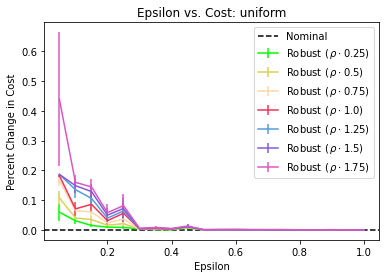

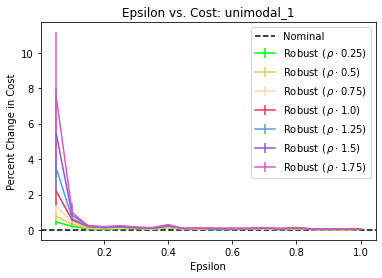

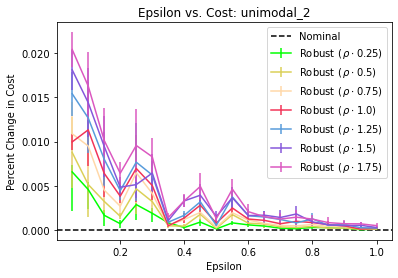

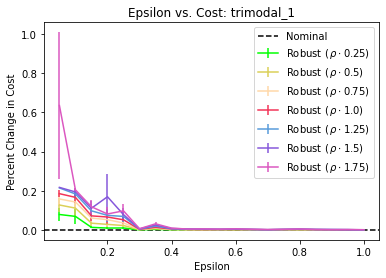

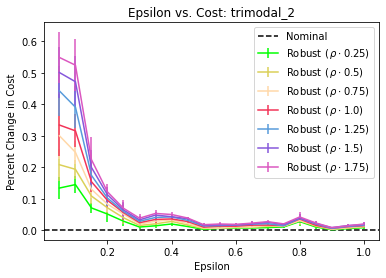

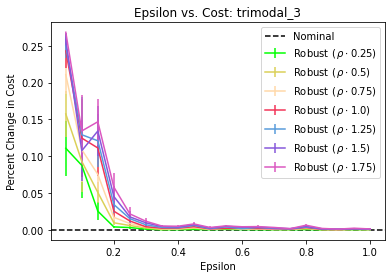

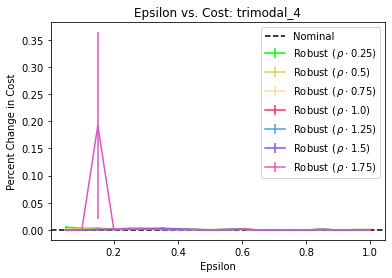

In [3]:
palette = sns.color_palette("hls", 7)
palette[3] = (0.95, 0.2, 0.34)
palette[0] = (0.0, 1.0, 0.0)
palette[2] = (1.0, 0.847, 0.659)

for file_num in range(len(files)): 
    df = pd.read_csv(files[file_num])
    df['Percent Change'] = (df['Robust Cost'] - df['Nominal Cost'])/df['Nominal Cost']
    percent_change = df.groupby(['Epsilon', 'Rho Multiplier'])['Percent Change'].apply(np.array).reset_index()
    percent_change['mean'] = percent_change['Percent Change'].apply(lambda x: x.mean())
    percent_change['error'] = percent_change['Percent Change'].apply(lambda x: x.std()/np.sqrt(len(x)))
    
    for i, mult in enumerate(percent_change['Rho Multiplier'].unique()): 
        selection = percent_change[percent_change['Rho Multiplier'] == mult]
        plt.errorbar(selection['Epsilon'].to_numpy(), selection['mean'].to_numpy(), yerr=selection['error'].to_numpy(), label=rf'Robust ($\,\rho \cdot ${mult})', color=palette[i])

    plt.axhline(y=0, color='black', linestyle="--", label="Nominal")
    plt.legend()
    plt.xlabel('Epsilon')
    plt.ylabel('Percent Change in Cost')
    name = "Epsilon vs. Cost: " + files[file_num].split(".")[0]
    plt.title(name)
    plt.show()

I think what this tells us is our $\rho$ multiplier step size is too small, since the error bars are overlapping with one another. Maybe for our final graphs, we can just pick three: $[0.25, 1, 1.75]$. The largest error bars are for $\varepsilon \leq 0.2$, which are also the regions where differential privacy has the largest effect on increasing the robust cost. 

## Plots Without Error Bars

Each point is the average out of $5$ trials. 

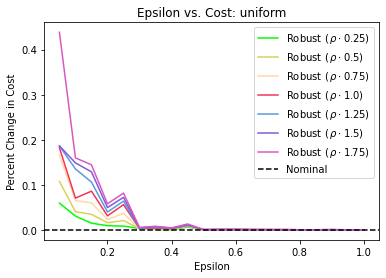

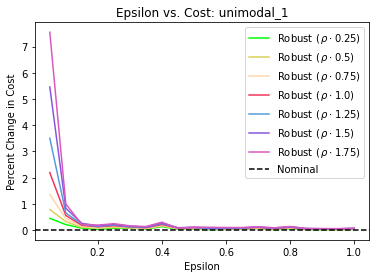

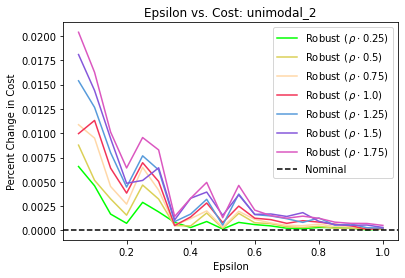

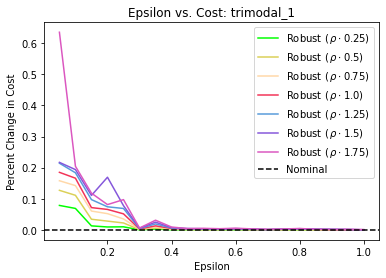

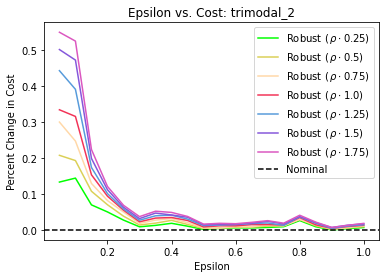

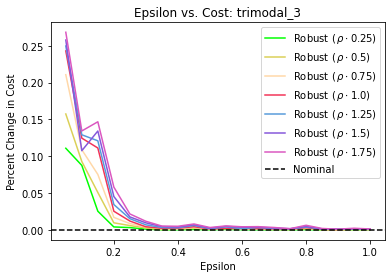

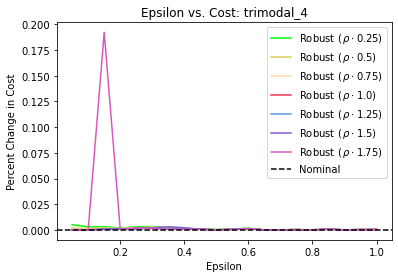

In [4]:
palette = sns.color_palette("hls", 7)
palette[3] = (0.95, 0.2, 0.34)
palette[0] = (0.0, 1.0, 0.0)
palette[2] = (1.0, 0.847, 0.659)

for file_num in range(len(files)): 
    df = pd.read_csv(files[file_num])
    df['Percent Change'] = (df['Robust Cost'] - df['Nominal Cost'])/df['Nominal Cost']
    percent_change = df.groupby(['Epsilon', 'Rho Multiplier'])['Percent Change'].apply(np.array).reset_index()
    percent_change['mean'] = percent_change['Percent Change'].apply(lambda x: x.mean())
    percent_change['error'] = percent_change['Percent Change'].apply(lambda x: x.std()/np.sqrt(len(x)))
    
    for i, mult in enumerate(percent_change['Rho Multiplier'].unique()): 
        selection = percent_change[percent_change['Rho Multiplier'] == mult]
        plt.plot(selection['Epsilon'].to_numpy(), selection['mean'].to_numpy(), label=rf'Robust ($\,\rho \cdot ${mult})', color=palette[i])

    plt.axhline(y=0, color='black', linestyle="--", label="Nominal")
    plt.legend()
    plt.xlabel('Epsilon')
    plt.ylabel('Percent Change in Cost')
    name = "Epsilon vs. Cost: " + files[file_num].split(".")[0]
    plt.title(name)
    plt.show()

## Workload Plots: 2D

In [5]:
def extract_probabilities_2d(workload_str): 
    pattern = r"=\s*([-+]?\d*\.\d+|\d+)"
    probs = [float(num) for num in re.findall(pattern, workload_str)]
    return [probs[0] + probs[1], probs[2], probs[3]]

In [6]:
def parse_workload_list_2d(workload_list):
    workloads = []
    for workload in workload_list: 
        workloads += [extract_probabilities_2d(workload)]
    
    x = [workload[0] for workload in workloads]    
    y = [workload[1] for workload in workloads]    
    gradient = [workload[2] for workload in workloads]
        
    return x, y, gradient

Make sure the gradient is the same across all epsilon values for writes

In [16]:
workloads = df.groupby(['Epsilon', 'Workload (True)'])['Workload (Perturbed)'].apply(np.array).reset_index()
workloads.head()

,Epsilon,Workload (True),Workload (Perturbed)
0,0.05,"Workload(z0=0.33, z1=0.33, q=0.33, w=0.01)","[Workload(z0=0.6092323882482747, z1=0.27319391..."
1,0.10,"Workload(z0=0.33, z1=0.33, q=0.33, w=0.01)","[Workload(z0=0.4819789681680656, z1=0.14797219..."
2,0.15,"Workload(z0=0.33, z1=0.33, q=0.33, w=0.01)","[Workload(z0=0.35957632284815205, z1=0.3471767..."
3,0.20,"Workload(z0=0.33, z1=0.33, q=0.33, w=0.01)","[Workload(z0=0.3359421807329493, z1=0.35578140..."
4,0.25,"Workload(z0=0.33, z1=0.33, q=0.33, w=0.01)","[Workload(z0=0.3024000977820516, z1=0.31492456..."


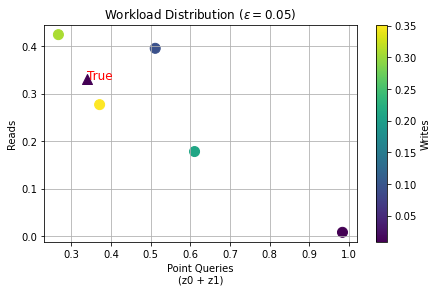

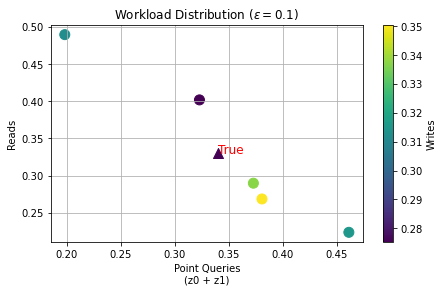

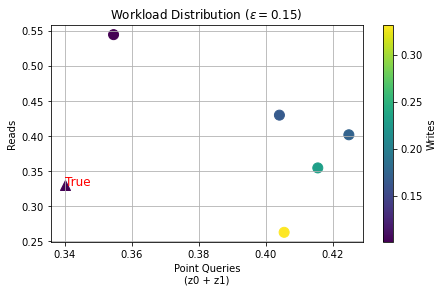

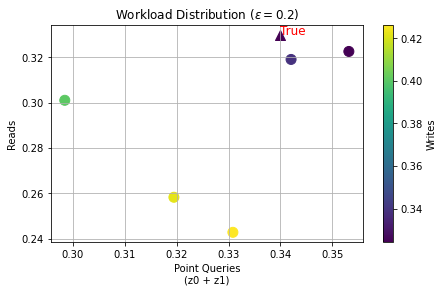

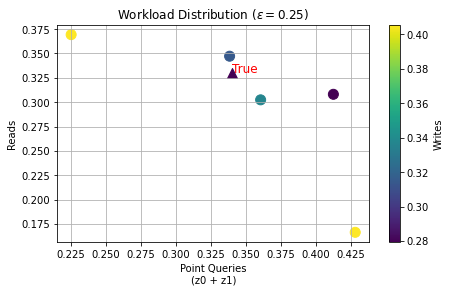

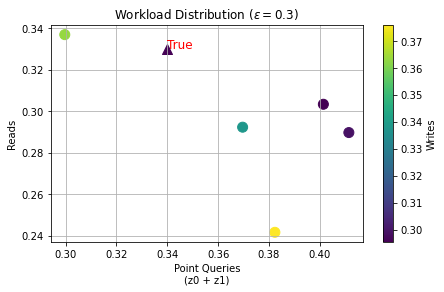

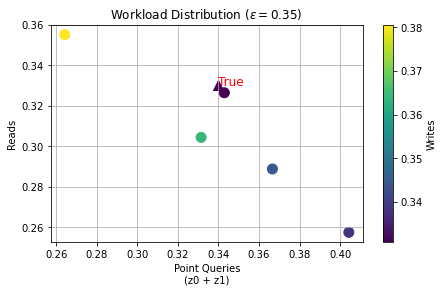

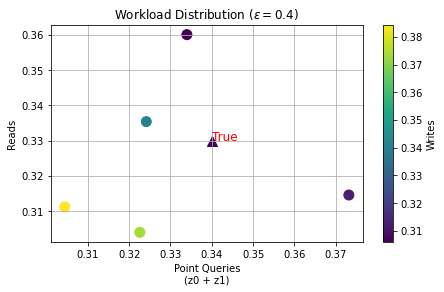

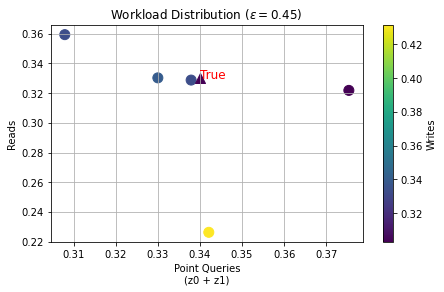

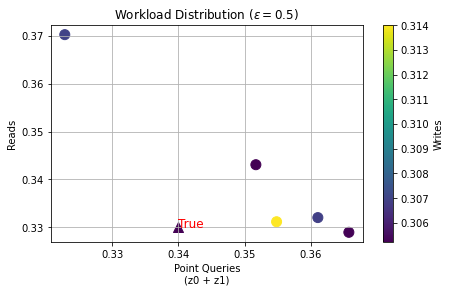

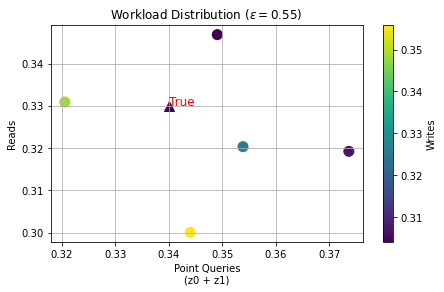

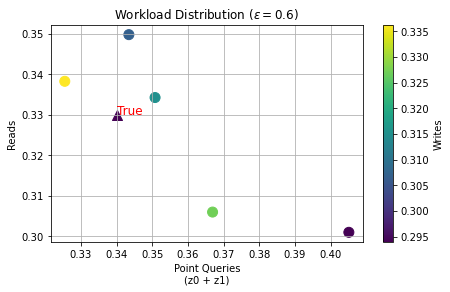

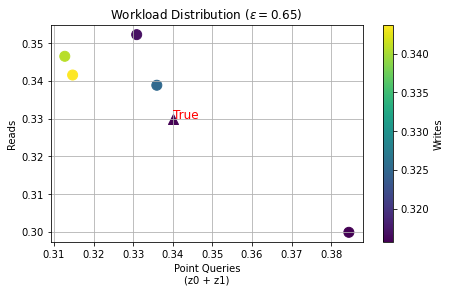

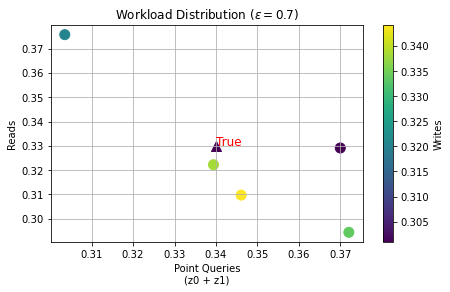

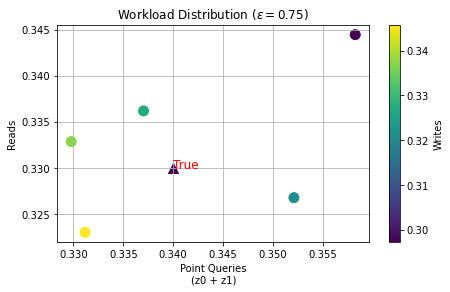

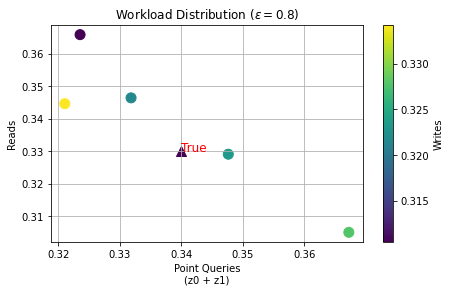

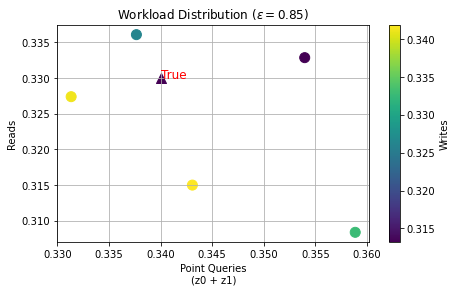

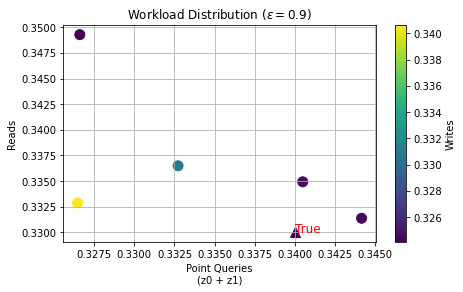

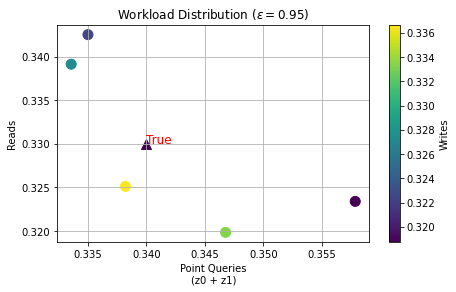

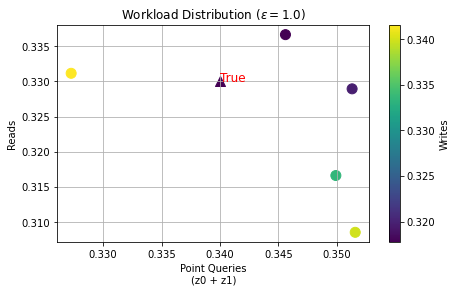

In [8]:
for epsilon in workloads['Epsilon'].unique():
    df = pd.read_csv('trimodal_1.csv')
    og = workloads[workloads['Epsilon'] == epsilon]['Workload (True)'].iloc[0]
    # (z0, z1, q, w)
    og = extract_probabilities_2d(og)
    wl_list = workloads[workloads['Epsilon'] == epsilon]['Workload (Perturbed)'].iloc[0]
    wl_list = list(set(wl_list))
    x, y, grad = parse_workload_list_2d(wl_list)

    plt.figure(figsize=(7, 4))
    scatter = plt.scatter(x, y, c=grad, cmap='viridis', s=100)
    plt.scatter([og[0]], [og[1]], c=[og[2]], cmap='viridis', marker='^', s=100)
    plt.text(og[0], og[1], 'True', fontsize=12, color='red')
    plt.colorbar(scatter, label='Writes')
    plt.xlabel('Point Queries\n(z0 + z1)')
    plt.ylabel('Reads')
    plt.title(rf'Workload Distribution ($\varepsilon = {round(epsilon, 2)}$)')
    plt.grid(True)
    plt.show()

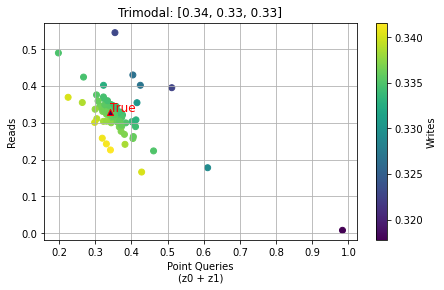

In [9]:
og = workloads.iloc[0]['Workload (True)']
matching = workloads[workloads['Workload (True)'] == og]
all_perturbed = np.concatenate(matching['Workload (Perturbed)'].values)
all_perturbed = list(set(all_perturbed))
x, y, grad = parse_workload_list_2d(all_perturbed)

fig, ax = plt.subplots(figsize=(7, 4))
og = extract_probabilities_2d(og)
ax.scatter(x, y, c=grad, cmap='viridis')
ax.scatter([og[0]], [og[1]], c=[og[2]], cmap='viridis', marker='^', edgecolor='red', linewidth=1)
ax.text(og[0], og[1], 'True', fontsize=12, color='red')
fig.colorbar(scatter, ax=ax, label='Writes')

ax.set_xlabel('Point Queries\n(z0 + z1)')
ax.set_ylabel('Reads')
ax.set_title(f'Trimodal: {og}')
ax.grid(True)

plt.show()

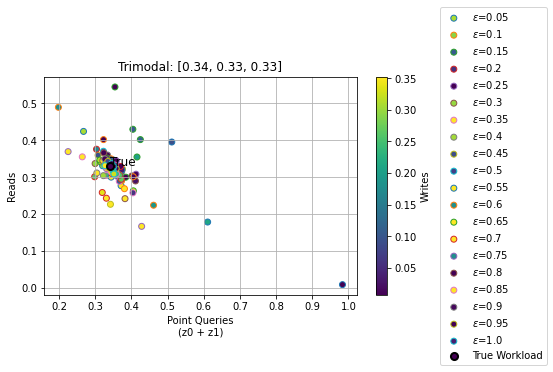

In [10]:
fig, ax = plt.subplots(figsize=(7, 4))

og = workloads.iloc[0]['Workload (True)']
og_vals = extract_probabilities_2d(og)


epsilon_values = sorted(workloads['Epsilon'].unique())
outline_colors = plt.cm.tab10.colors 

for idx, epsilon in enumerate(epsilon_values):
    matching = workloads[(workloads['Workload (True)'] == og) & 
                         (workloads['Epsilon'] == epsilon)]
    
    if not matching.empty:
        perturbed = np.concatenate(matching['Workload (Perturbed)'].values)
        perturbed = list(set(perturbed))
        x, y, grad = parse_workload_list_2d(perturbed)

        ax.scatter(x, y, c=grad, cmap='viridis',
                   edgecolor=outline_colors[idx % len(outline_colors)],
                   linewidth=1, label=rf'$\varepsilon$={round(epsilon, 2)}')

ax.scatter([og_vals[0]], [og_vals[1]], c=[og_vals[2]], cmap='viridis',
           edgecolor='black', linewidth=2, s=50, label='True Workload')
ax.text(og_vals[0], og_vals[1], 'True', fontsize=12, color='black')

fig.colorbar(ax.collections[0], ax=ax, label='Writes')
ax.set_xlabel('Point Queries\n(z0 + z1)')
ax.set_ylabel('Reads')
ax.set_title(f'Trimodal: {og_vals}')
ax.grid(True)
ax.legend(loc='center left', bbox_to_anchor=(1.25, 0.5))

plt.show()

## 3D Workload Plots

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import matplotlib.colors as mcolors

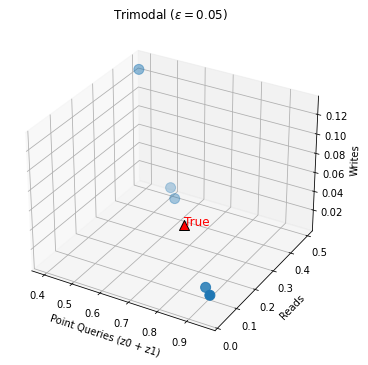

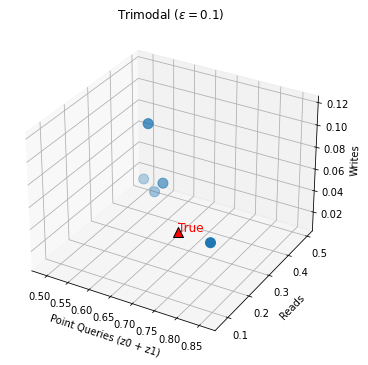

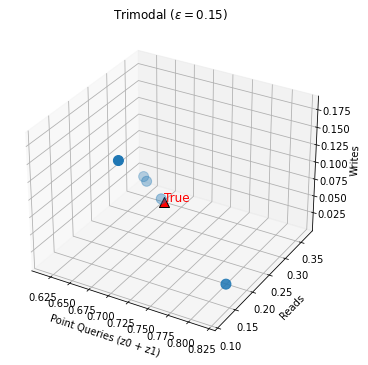

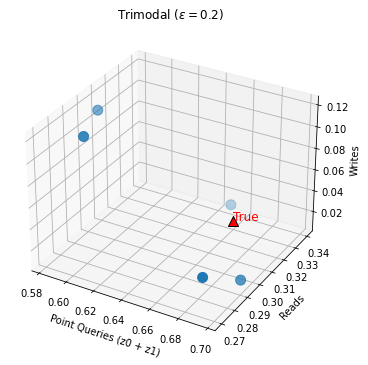

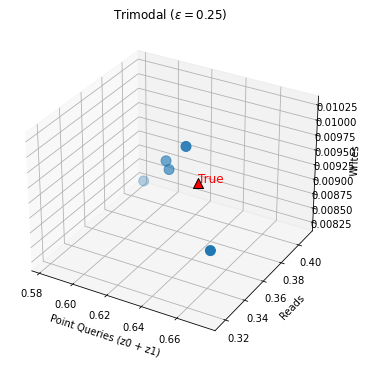

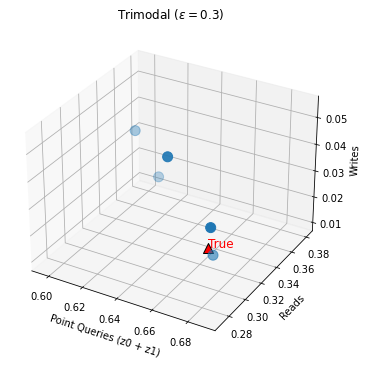

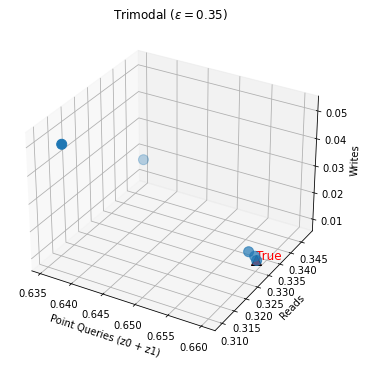

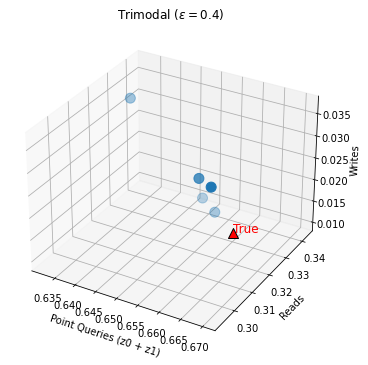

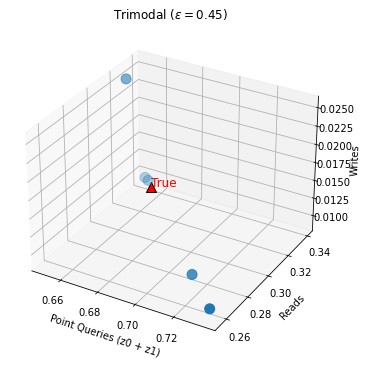

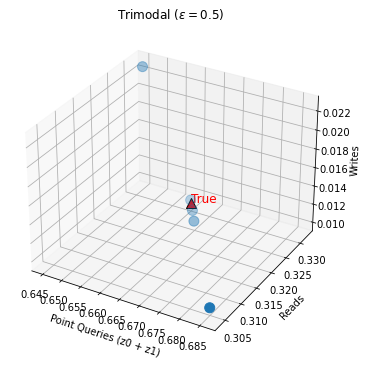

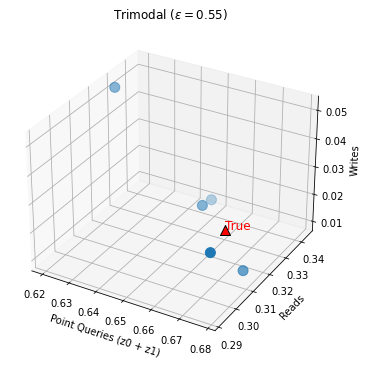

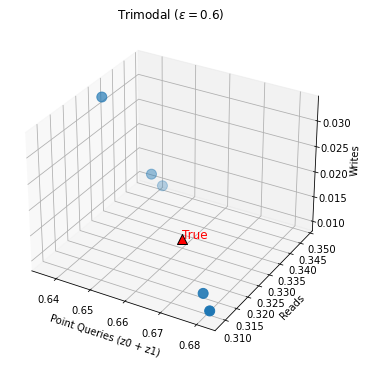

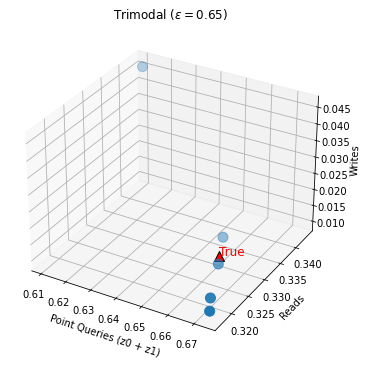

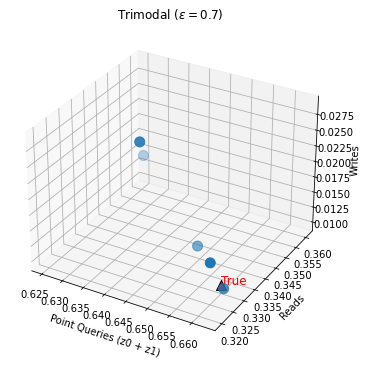

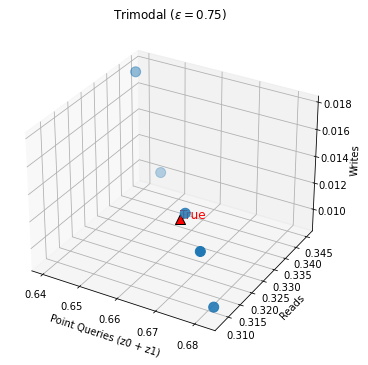

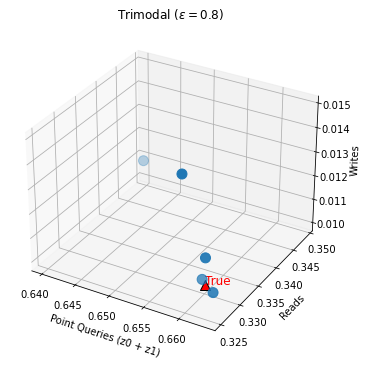

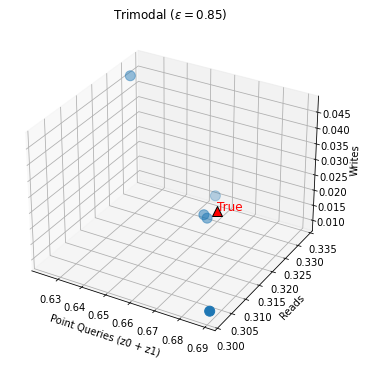

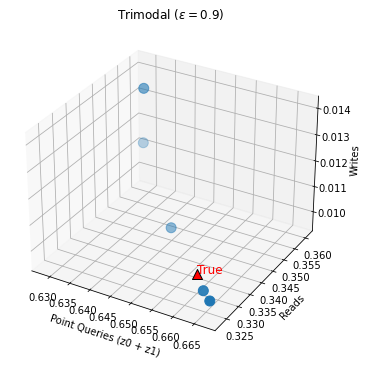

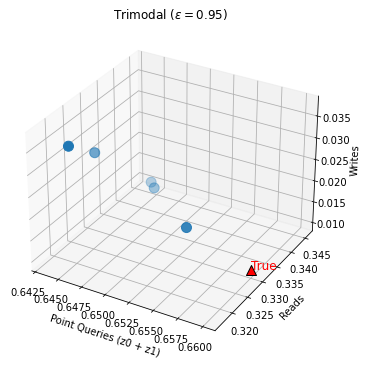

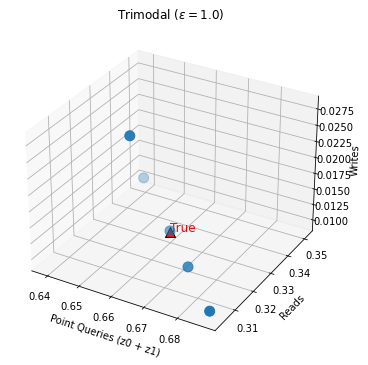

In [12]:
for epsilon in workloads['Epsilon'].unique():
    df = pd.read_csv('trimodal_1.csv')
    workloads = df.groupby(['Epsilon', 'Workload (True)'])['Workload (Perturbed)'].apply(np.array).reset_index()
    og = workloads[workloads['Epsilon'] == epsilon]['Workload (True)'].iloc[0]
    # (z0, z1, q, w)
    og = extract_probabilities_2d(og)

    wl_list = workloads[workloads['Epsilon'] == epsilon]['Workload (Perturbed)'].iloc[0]
    wl_list = list(set(wl_list))

    x, y, z = parse_workload_list_2d(wl_list)

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(x, y, z, s=100, marker='o')
    ax.scatter(og[0], og[1], og[2], c='red', s=100, marker='^', edgecolors='black', label='True')
    ax.text(og[0], og[1], og[2], 'True', fontsize=12, color='red')

    ax.set_xlabel('Point Queries (z0 + z1)')
    ax.set_ylabel('Reads')
    ax.set_zlabel('Writes')

    ax.set_title(rf'Trimodal ($\varepsilon = {round(epsilon, 2)}$)')
    ax.grid(True)
    plt.show()

In [13]:
def extract_probabilities_3d(workload_str): 
    pattern = r"=\s*([-+]?\d*\.\d+|\d+)"
    dist = [float(num) for num in re.findall(pattern, workload_str)]
    # z0, q, w, z1
    dist = [dist[0], dist[2], dist[3], dist[0]]
    return dist

In [14]:
def parse_workload_list_3d(workload_list):
    workloads = []
    for workload in workload_list: 
        workloads += [extract_probabilities_3d(workload)]
    
    x = [workload[0] for workload in workloads]    
    y = [workload[1] for workload in workloads]    
    z = [workload[2] for workload in workloads]
    gradient = [workload[3] for workload in workloads]
        
    return x, y, z, gradient

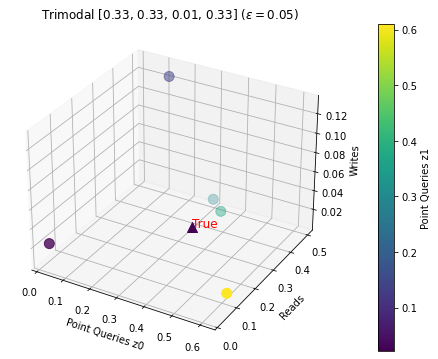

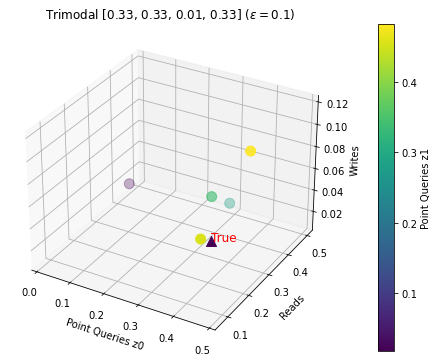

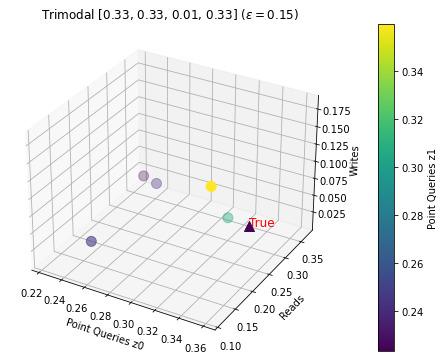

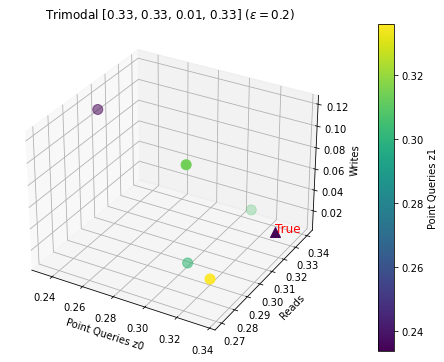

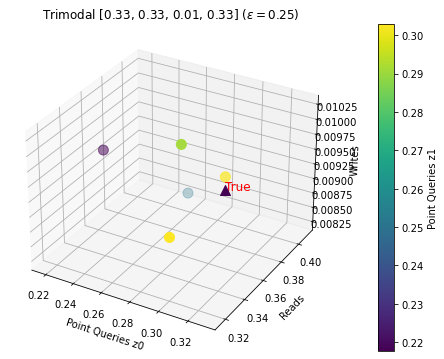

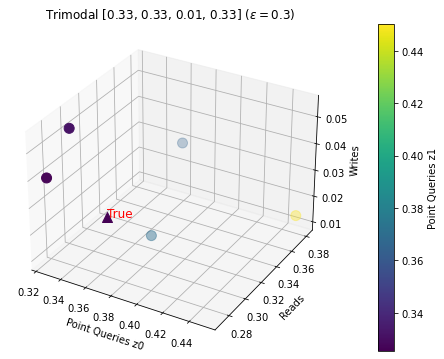

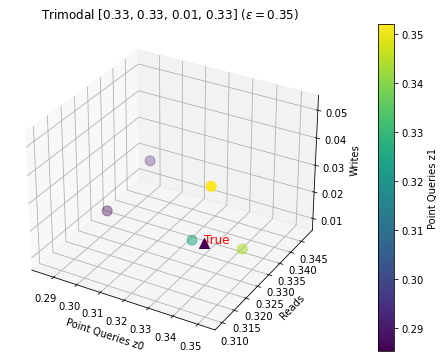

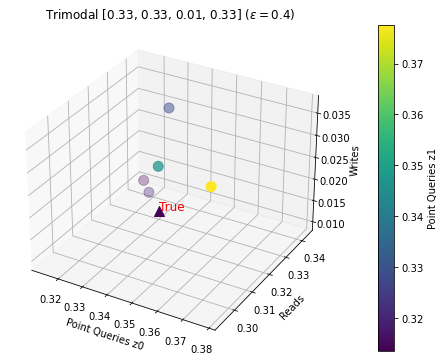

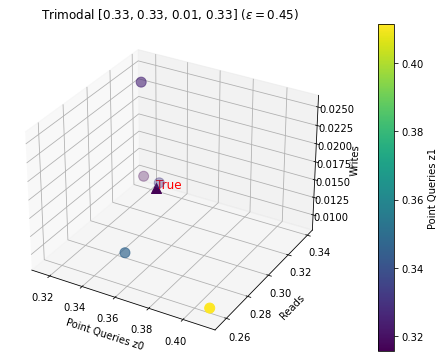

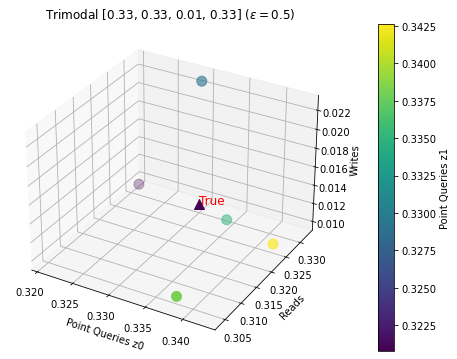

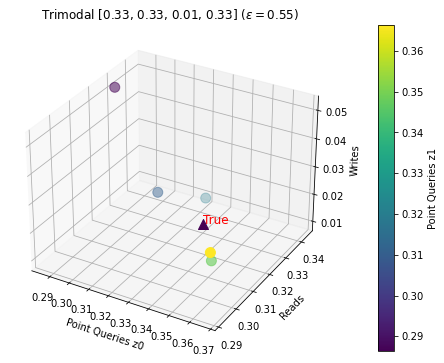

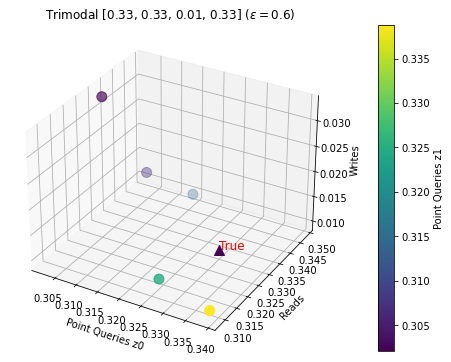

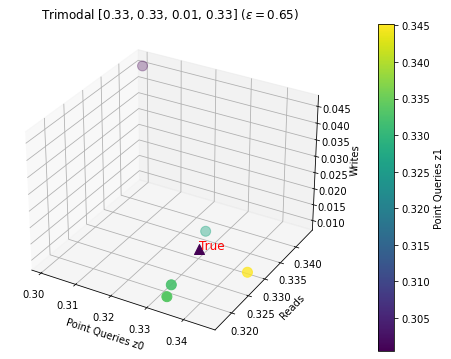

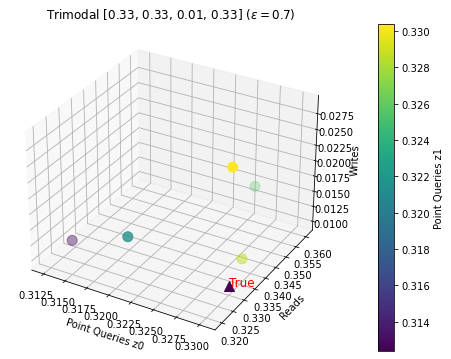

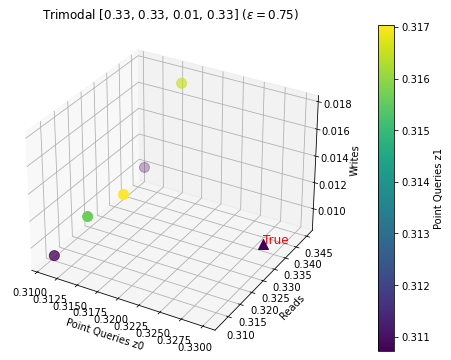

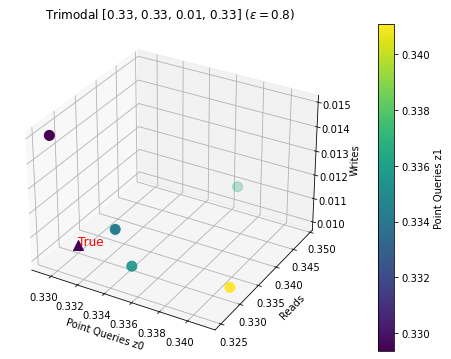

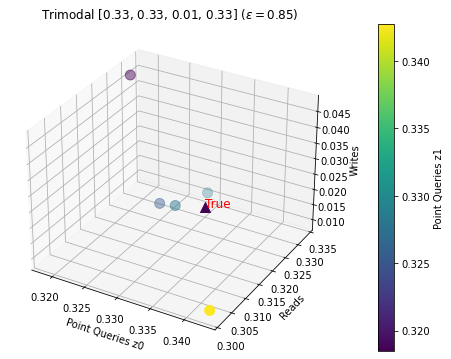

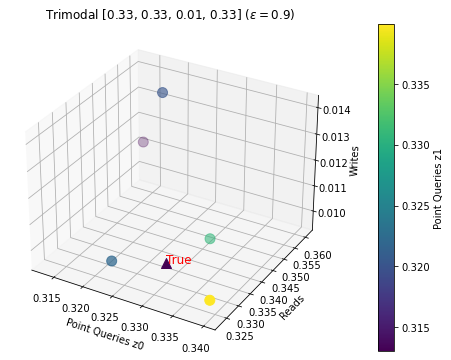

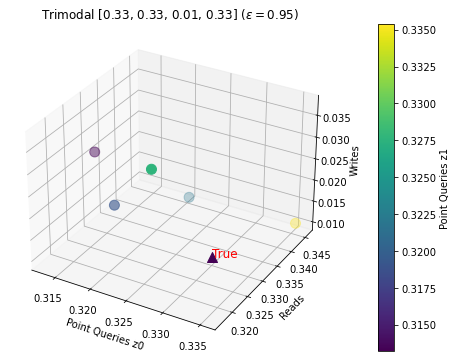

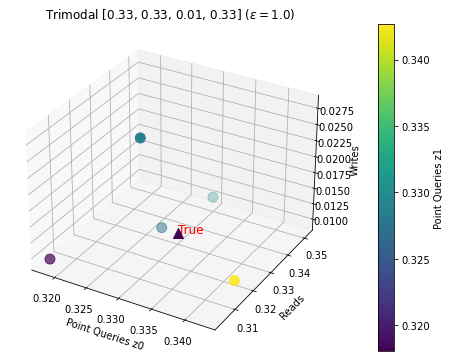

In [15]:
for epsilon in workloads['Epsilon'].unique():
    df = pd.read_csv('trimodal_1.csv')
    workloads = df.groupby(['Epsilon', 'Workload (True)'])['Workload (Perturbed)'].apply(np.array).reset_index()
    og = workloads[workloads['Epsilon'] == epsilon]['Workload (True)'].iloc[0]
    # (z0, z1, q, w)
    og = extract_probabilities_3d(og)

    wl_list = workloads[workloads['Epsilon'] == epsilon]['Workload (Perturbed)'].iloc[0]
    wl_list = list(set(wl_list))

    x, y, z, grad = parse_workload_list_3d(wl_list)

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(x, y, z, c=grad, cmap='viridis', s=100, marker='o')
    ax.scatter(og[0], og[1], og[2], c=[og[3]], cmap='viridis', s=100, marker='^', label='True')
    ax.text(og[0], og[1], og[2], 'True', fontsize=12, color='red')
    plt.colorbar(scatter, label='Point Queries z1', pad=0.1)

    ax.set_xlabel('Point Queries z0')
    ax.set_ylabel('Reads')
    ax.set_zlabel('Writes')

    ax.set_title(rf'Trimodal {og} ($\varepsilon = {round(epsilon, 2)}$)')
    ax.grid(True)
    plt.show()